## Requisite packages installation

In [7]:
!pip install webdriver-manager
!pip install selenium
!pip install chromedriver-py
!pip install PyPDF2
!pip install wordcloud

## Configuring the json files 

In [8]:
# Saved file for each job info
JOBS_INFO_JSON_FILE = r'C:/Users/TANNI/Desktop/CLASS NOTES/SEM4/indeed_jobs_infos.json'
# Path to webdriver exe
WEBDRIVER_PATH = r'D:\chromedriver\chromedriver.exe'
# City to search: Boston,MA
JOB_LOCATIONS = ['Boston,MA']
JOB_SEARCH_WORDS = 'data scientist'
# To avoid same job posted multiple times, we only look back for 30 days
DAY_RANGE = 305
# Path to sample resume
SAMPLE_RESUME_PDF = r'C:/Users/TANNI/Desktop/CLASS NOTES/SEM4/CO_OP/RESUME/Tannishtha_Mandal_DS_ML.pdf'


## Web Scraping Code

In [9]:
import random, json
import numpy as np
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time, os


# We only collect max 500 
max_results_per_city = 500
# Number of jobs show on each result page
page_record_limit = 50
num_pages = int(max_results_per_city/page_record_limit)

def get_jobs_info(search_location):
    '''
    Scrape from web or read from saved file
    Input: 
        search_location - search job in a certain city. Input from command line.
    Output: 
        jobs_info - a list that has info of each job i.e. link, location, title, company, salary, desc
    '''
    exists = os.path.isfile(JOBS_INFO_JSON_FILE)
    # print("exists", exists)
    jobs_info = web_scrape(search_location)
    if exists:
        with open(JOBS_INFO_JSON_FILE, 'r') as fp:
            jobs_info = json.load(fp)            
    else:
        jobs_info = web_scrape(search_location)
        
    return jobs_info
        
def web_scrape(search_location):
    '''
    Scrape jobs from indeed.ca
    Input: 
        search_location - search job in a certain city. Input from commond line.
    Output: 
        jobs_info - a list that has info of each job i.e. link, location, title, company, salary, desc
    '''
    # urls of all jobs
    job_links = []
    # Record time for web scraping
    # start time
    start = time.time() 
    # Launch webdriver
    driver = webdriver.Chrome(WEBDRIVER_PATH)
    job_locations = JOB_LOCATIONS
    # If search location is defined, only search that location
    if (len(search_location) > 0):
        job_locations = [search_location]
        
    # Extract all job urls 
    for location in job_locations: 
        url = 'https://www.indeed.com/jobs?q='+ JOB_SEARCH_WORDS + '&l=' \
        + location + '&limit=' + str(page_record_limit) + '&fromage='+ str(DAY_RANGE)
        # Set timeout
        driver.set_page_load_timeout(80)
        webdriver.DesiredCapabilities.CHROME["unexpectedAlertBehaviour"] = "accept"
        driver.get(url)
        time.sleep(5)  
        for i in range(num_pages):            
            try:
                # Each job on the page's its url
                from selenium.webdriver.common.by import By
                job_names = []
                company_names = []
                job_locations =[]
                job_descs = []
                for job_each in driver.find_elements(By.XPATH, "//h2[@class='jobTitle css-1h4a4n5 eu4oa1w0']"):
                    job_name = job_each.text
                    job_names.append(job_name)
                for job_each in driver.find_elements(By.XPATH, "//a[@data-tn-element='companyName']"):
                    company_name = job_each.text
                    company_names.append(company_name)
                for job_each in driver.find_elements(By.XPATH, "//div[@class ='companyLocation']"):
                    job_location = job_each.text
                    job_locations.append(job_location)
                for job_each in driver.find_elements(By.XPATH, "//div[@id = 'jobDescriptionText']"):
                    job_desc = job_each.text
                    job_descs.append(job_desc)
                cd = [job_each for job_each in driver.find_elements(By.XPATH, "//div[@class = 'slider_container css-g7s71f eu4oa1w0']")]
                # [jd.text for jd in driver.find_elements(By.XPATH, "//div[@id = 'jobDescriptionText']")]
                # cd[2].click()
                
                result = []
                for i in range(5):
                    driver.get(url)
                    time.sleep(5)  
                    cd = [job_each for job_each in driver.find_elements(By.XPATH, "//div[@class = 'slider_container css-g7s71f eu4oa1w0']")]
                    if i<len(cd):
                        cd[i].click()
                        time.sleep(5) 
                        result.append([jd.text for jd in driver.find_elements(By.XPATH, "//div[@id = 'jobDescriptionText']")])
                job_desc = [i[0] for i in result]
                # print("\n\nresult:",result)
                # slider_container css-g7s71f eu4oa1w0
                # print("job_names: \n", job_names)
                # print("company_names: \n", company_names)
                # print("location:\n", job_locations)
                # print("job_Desc:\n", job_descs)
                zipped = zip(job_names, company_names, job_locations, job_desc)
                zipped_list = list(zipped)
                # print(zipped_list)
                print ('scraping {} page {}'.format(location, i+1))
                # Go next page
                driver.find_element(By.LINK_TEXT,'Next »').click()
            except NoSuchElementException:
                # If nothing find, we are at the end of all returned results
                print ("{} finished".format(location))
                break        
            time.sleep(3)
    with open(JOBS_INFO_JSON_FILE, 'w') as fp:
        json.dump(zipped_list, fp)
    # Close and quit webdriver
    driver.quit()    
    end = time.time() # end time
    # Calculate web scaping time
    scaping_time = (end-start)/60.
    print('Took {0:.2f} minutes scraping {1:d} data scientist jobs'.format(scaping_time, len(zipped_list)))
    return zipped_list

## Match Job Skills with Resume

In [10]:
import re
from nltk.corpus import stopwords
from collections import Counter 
import pandas as pd
import PyPDF2
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.spatial.distance import cosine
from random import randint
import numpy as np

# The following data science skill sets are modified from 
program_languages = ['bash','r','python','java','c++','ruby','perl','matlab','javascript','scala','php']
analysis_software = ['excel','tableau','sas','spss','d3','saas','pandas','numpy','scipy','sps','spotfire','scikit','splunk','power','h2o']
ml_framework = ['pytorch','tensorflow','caffe','caffe2','cntk','mxnet','paddle','keras','bigdl']
bigdata_tool = ['hadoop','mapreduce','spark','pig','hive','shark','oozie','zookeeper','flume','mahout','etl']
ml_platform = ['aws','azure','google','ibm']
methodology = ['agile','devops','scrum']
databases = ['sql','nosql','hbase','cassandra','mongodb','mysql','mssql','postgresql','oracle','rdbms','bigquery']
overall_skills_dict = program_languages + analysis_software + ml_framework + bigdata_tool + databases + ml_platform + methodology
education = ['master','phd','undergraduate','bachelor','mba']
overall_dict = overall_skills_dict + education
# specify the length of each minhash vector
N = 32
max_val = (2**8)-1
# create N tuples that will serve as permutation functions.These permutation values are used to hash all input sets
perms = [ (randint(0,max_val), randint(0,max_val)) for i in range(N)]
#Initialize a sample minhash vector of length N.Each record will be represented by its own vec
vec = [float('inf') for i in range(N)]


class skill_keyword_match:
    jobs_info_df = None
    def __init__(self, jobs_list):
        '''
        Initialization - converts list to DataFrame
        Input: 
            jobs_list (list): a list of all jobs info
        Output: 
            None
        '''
        self.jobs_info_df = pd.DataFrame(jobs_list) 

        self.jobs_info_df.rename(columns = {'0':'job_title','1':'company_name', '2':'location','3':'job_desc'})
        print("Dataset:\n")
        print(self.jobs_info_df.head(5))
        
        
    def keywords_extract(self, text): 
        '''
        Tokenize webpage text and extract keywords
        Input: 
            text (str): text to extract keywords from
        Output: 
            keywords (list): keywords extracted and filtered by pre-defined dictionary
        '''        
        text = re.sub("[^a-zA-Z+3]"," ", text) 
        text = text.lower().split()
        stops = set(stopwords.words("english")) 
        #filter out stop words in english language
        text = [w for w in text if not w in stops]
        text = list(set(text))
        #keywords from the pre-defined skill dictionary
        keywords = [str(word) for word in text if word in overall_dict]
        return keywords
 
    def keywords_count(self, keywords, counter): 
        '''
        Count frequency of keywords
        Input: 
            keywords (list): list of keywords
            counter (Counter)
        Output: 
            keyword_count (DataFrame index:keyword value:count)
        '''           
        keyword_count = pd.DataFrame(columns = ['Freq'])
        for each_word in keywords: 
            keyword_count.loc[each_word] = {'Freq':counter[each_word]}
        return keyword_count
    
    def exploratory_data_analysis(self):
        '''
        Exploratory data analysis
        Input: 
            None
        Output: 
            None
        '''         
        #Counter of keywords
        doc_freq = Counter() 
        f = [doc_freq.update(item) for item in self.jobs_info_df['keywords']]        
        #Pre-defined skillset vocabulary in Counter
        overall_skills_df = self.keywords_count(overall_skills_dict, doc_freq)
        # Calculate percentage of required skills in all jobs
        overall_skills_df['Freq_perc'] = (overall_skills_df['Freq'])*100/self.jobs_info_df.shape[0]
        overall_skills_df = overall_skills_df.sort_values(by='Freq_perc', ascending=False)  
        # Bar plot 
        plt.figure(figsize=(14,8))
        overall_skills_df.iloc[0:30, overall_skills_df.columns.get_loc('Freq_perc')].plot.bar()
        plt.title('Percentage of Required Data Skills in Data Scientist Job Posts')
        plt.ylabel('Percentage Required in Jobs (%)')
        plt.xticks(rotation=30)
        plt.show()     
         
        #Education requirements
        education_df = self.keywords_count(education, doc_freq)
        #Merge undergrad with bachelor
        education_df.loc['bachelor','Freq'] = education_df.loc['bachelor','Freq'] + education_df.loc['undergraduate','Freq'] 
        education_df.drop(labels='undergraduate', axis=0, inplace=True)
        #Calculate percentage of required skills in all jobs
        education_df['Freq_perc'] = (education_df['Freq'])*100/self.jobs_info_df.shape[0] 
        education_df = education_df.sort_values(by='Freq_perc', ascending=False)  
        
        
    def get_jaccard_sim(self, x_set, y_set): 
        '''
        Jaccard similarity or intersection over union measures similarity 
        between finite sample sets,  and is defined as size of intersection 
        divided by size of union of two sets. 
        
        Input: 
            x_set (set)
            y_set (set)
        Output: 
            Jaccard similarity score
        '''         
        intersection = x_set.intersection(y_set)
        return float(len(intersection)) / (len(x_set) + len(y_set) - len(intersection))
    
    
    def cal_similarity(self, resume_keywords, location=None):
        '''
        Calculate similarity between keywords from resume and job posts
        Input: 
            resume_keywords (list): resume keywords
            location (str): city to search jobs
        Output: 
            top_match (DataFrame): top job matches
        '''     
        num_jobs_return = 20
        similarity = []
        j_info = self.jobs_info_df
        if j_info.shape[0] < num_jobs_return:        
            num_jobs_return = j_info.shape[0]  
        for job_skills in j_info['keywords']:
            similarity.append(self.get_jaccard_sim(set(resume_keywords), set(job_skills)))
        j_info['similarity'] = similarity
        top_match = j_info.sort_values(by='similarity', ascending=False).head(num_jobs_return)        
        #Return top matched jobs
        return top_match
      
        
    def extract_jobs_keywords(self):
        '''
        Extract skill keywords from job descriptions and add a new column 
        Input: 
            None
        Output: 
            None
        
        '''
        self.jobs_info_df.head(5)
        self.jobs_info_df['keywords'] = [self.keywords_extract(job_desc) for job_desc in self.jobs_info_df[3]]
        
        
    def extract_resume_keywords(self, resume_pdf): 
        '''
        Extract key skills from a resume 
        Input: 
            resume_pdf (str): path to resume PDF file
        Output: 
            resume_skills (DataFrame index:keyword value:count): keywords counts
        ''' 
        #Open resume PDF
        resume_file = open(resume_pdf, 'rb')
        #CreatE a pdf reader object
        resume_reader = PyPDF2.PdfFileReader(resume_file)
        #Read in each page in PDF
        resume_content = [resume_reader.getPage(x).extractText() for x in range(resume_reader.numPages)]
        #Extract key skills from each page
        resume_keywords = [self.keywords_extract(page) for page in resume_content]
        #Count keywords
        resume_freq = Counter() 
        f = [resume_freq.update(item) for item in resume_keywords] 
        # Get resume skill keywords counts
        resume_skills = self.keywords_count(overall_skills_dict, resume_freq)
        
        return(resume_skills[resume_skills['Freq']>0])
            
    def calculate_minhash(self, resume_keywords):
        num_jobs_return = 10
        j_info = self.jobs_info_df
        minhash_similarity =[]
        
        for job_skills in j_info['keywords']:
            
            #Specify some input sets
            data_resume = set(resume_keywords)
            data_job_keywords = set(job_skills)
            #Minhash vectors for each input set
            vec1 = self.minhash(data_resume)
            vec2 = self.minhash(data_job_keywords)

            #Divide both vectors by their max values to scale values {0:1}
            vec1 = np.array(vec1) / max(vec1)
            vec2 = np.array(vec2) / max(vec2)
            cos_sim = 1 - cosine(vec1, vec2)
            minhash_similarity.append(cos_sim)
            # measure the similarity between the vectors using cosine similarity
            print( '\n Minhash using similarity:', cos_sim )
            
        j_info['Minhash_Similarity'] = minhash_similarity
        top_match_minhash = j_info.sort_values(by='similarity', ascending=False).head(num_jobs_return)        
        #Return top matched jobs
        return top_match_minhash
    
    def minhash(self, s ,prime=4294967311):
        vec = [float('inf') for i in range(N)]
        
        for val in s:
            if not isinstance(val, int): val = hash(val)
            for perm_idx, perm_vals in enumerate(perms):
                a,b = perm_vals
                output = (a * val + b) % prime
                if vec[perm_idx]>output:
                    vec[perm_idx] = output
        return vec

C:\Users\TANNI\AppData\Local\Temp\ipykernel_72996\1331535218.py:47: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(WEBDRIVER_PATH)


scraping Boston,MA page 5
Boston,MA finished
Took 1.24 minutes scraping 5 data scientist jobs
Dataset:

                                            0                      1  \
0                          Data Scientist III                 MAPFRE   
1  Associate Director Statistical Programming           Novo Nordisk   
2                     Scientist, Data Science  Takeda Pharmaceutical   
3                              Data Scientist  Takeda Pharmaceutical   
4                              Data Scientist  Takeda Pharmaceutical   

                                      2  \
0                            Boston, MA   
1            Lexington, MA\n+1 location   
2     Lexington, MA 02420\n+3 locations   
3     Boston, MA 02112 \n(Central area)   
4  Hybrid remote in Lexington, MA 02420   

                                                   3  
0  This is a high level Data Science role on our ...  
1  About the Department\nThe AI and Analytics Tea...  
2  By clicking the “Apply” button, I un

C:\Users\TANNI\AppData\Local\Temp\ipykernel_72996\2843800679.py:211: RuntimeWarning: invalid value encountered in true_divide
  vec2 = np.array(vec2) / max(vec2)


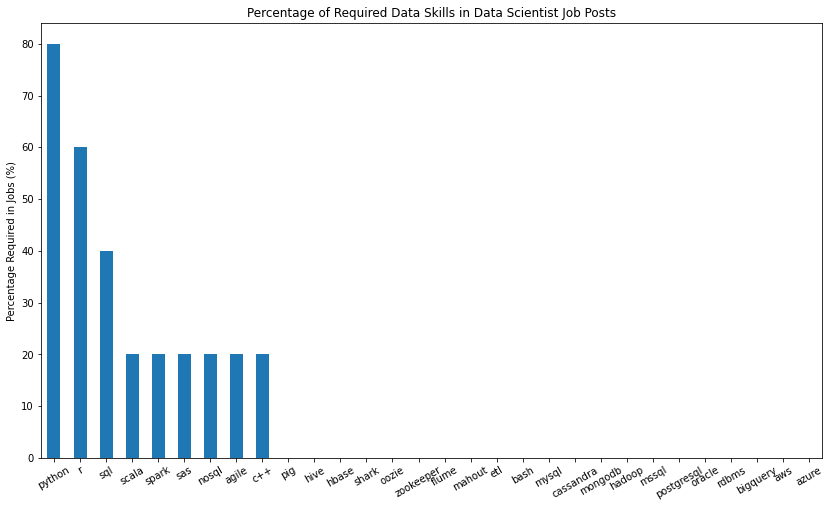

,0,1,2,3,keywords,similarity,Minhash_Similarity
2,"Scientist, Data Science",Takeda Pharmaceutical,"Lexington, MA 02420\n+3 locations","By clicking the “Apply” button, I understand t...","[scala, c++, phd, python, r, sql]",0.157895,0.669425
0,Data Scientist III,MAPFRE,"Boston, MA",This is a high level Data Science role on our ...,"[python, sql, bachelor, master, spark]",0.105263,0.670998
3,Data Scientist,Takeda Pharmaceutical,"Boston, MA 02112 \n(Central area)","By clicking the “Apply” button, I understand t...","[sas, python, r]",0.055556,0.625893
1,Associate Director Statistical Programming,Novo Nordisk,"Lexington, MA\n+1 location",About the Department\nThe AI and Analytics Tea...,"[master, python, agile, r, bachelor, nosql]",0.047619,0.628138
4,Data Scientist,Takeda Pharmaceutical,"Hybrid remote in Lexington, MA 02420",Salary: commensurate with experience\nReferenc...,[],0.000000,1.000000


In [14]:
import sys 
#Search and recommend jobs in Boston.
location = 'Boston,MA'
#Scrape from web or read from local saved
jobs_info = get_jobs_info(location)    
#Keyword extraction and analysis. Initialize skill_keyword_match with job_info.
skill_match = skill_keyword_match(jobs_info)
#Extract skill keywords from job descriptions 
skill_match.extract_jobs_keywords()
#Job recommendation based on skill matching 
resume_skills = skill_match.extract_resume_keywords(SAMPLE_RESUME_PDF)
#print("resume skills : ", resume_skills)
#Calculate similarity of skills from a resume and job posts 
top_job_matches = skill_match.cal_similarity(resume_skills.index, location)
print("Top matches with jaccard similarity\n:")
print(top_job_matches)
top_job_matches_minhash = skill_match.calculate_minhash(resume_skills.index)
print("\nTop matches with cosine similarity using minhash\n:")
print(top_job_matches_minhash)
#Data Visualization.
skill_match.exploratory_data_analysis()
top_job_matches_minhash